In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import csv
import sys
import pandas as pd
import time

In [2]:
from six.moves import cPickle as pickle

In [4]:
with open('../intermediateData/aggTrainingData.pickle', 'rb') as pickleFile:
    aggTrainingData = pickle.load(pickleFile, encoding='latin-1') 
with open('../intermediateData/aggTestingData.pickle', 'rb') as pickleFile:
    aggTestingData = pickle.load(pickleFile, encoding='latin-1') 
with open('../intermediateData/aggLoad.pickle', 'rb') as pickleFile:
    aggLoad = pickle.load(pickleFile, encoding='latin-1') 

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [7]:
# aggLoad[0:24]

In [8]:
## traing data structure
# constants for tues-fri and sat-mon
# linear terms for 24 hour lag for tues-fri and sat-mon
# linear terms for 168 hour lag for tues-fri and sat-mon
# temp const, linear quad X 4 day sections
[(x[2],x[4]) for x in aggTrainingData[0:5]]

[(179.76599999999993, 268.628),
 (169.9300000000001, 262.4930000000001),
 (166.3389999999999, 250.31199999999993),
 (177.69700000000006, 248.88500000000002),
 (197.27999999999977, 262.0730000000001)]

In [9]:
aggTrainingData = aggTrainingData.astype('float32')
aggLoad[168:192], aggTrainingData[0:24]

(2015-01-08 00:00:00    294.471
 2015-01-08 01:00:00    299.324
 2015-01-08 02:00:00    301.725
 2015-01-08 03:00:00    308.153
 2015-01-08 04:00:00    318.884
 2015-01-08 05:00:00    343.406
 2015-01-08 06:00:00    409.541
 2015-01-08 07:00:00    434.748
 2015-01-08 08:00:00    379.521
 2015-01-08 09:00:00    357.275
 2015-01-08 10:00:00    336.465
 2015-01-08 11:00:00    346.022
 2015-01-08 12:00:00    317.574
 2015-01-08 13:00:00    335.512
 2015-01-08 14:00:00    323.688
 2015-01-08 15:00:00    324.868
 2015-01-08 16:00:00    345.387
 2015-01-08 17:00:00    458.012
 2015-01-08 18:00:00    483.139
 2015-01-08 19:00:00    480.902
 2015-01-08 20:00:00    463.365
 2015-01-08 21:00:00    416.324
 2015-01-08 22:00:00    358.411
 2015-01-08 23:00:00    302.671
 dtype: float64,
 array([[ 1.00000e+00,  0.00000e+00,  1.79766e+02,  0.00000e+00,
          2.68628e+02,  0.00000e+00, -3.70000e+00,  1.36900e+01,
          1.00000e+00, -0.00000e+00,  0.00000e+00,  0.00000e+00,
         -0.00000e+0

In [10]:
np.shape(aggTrainingData)

(5664, 18)

In [11]:
# create and fit Multilayer Perceptron model
mdl = Sequential()
# first hidden layer, input tensor has dimension of y trainingData
mdl.add(Dense(units=18, input_dim=18, activation='relu'))
# second hidden layer with 8 nodes
mdl.add(Dense(units=20, activation='relu'))
# output layer
mdl.add(Dense(units=1))
mdl.compile(loss='mean_squared_error', optimizer='adam')

In [12]:
mdl.fit(aggTrainingData, aggLoad[168:5664+168], epochs=200, batch_size=2, verbose=0)

In [13]:
# estimate model performance
train_score = mdl.evaluate(aggTrainingData, aggLoad[168:5664+168], verbose=0)
print('Train Score: {:.2f} MSE ({:.2f} RMSE)'.format(train_score, math.sqrt(train_score)))
test_score = mdl.evaluate(aggTestingData, aggLoad[5832:7296], verbose=0)
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(test_score, math.sqrt(test_score)))

Train Score: 1695.57 MSE (41.18 RMSE)
Test Score: 2339.01 MSE (48.36 RMSE)


In [14]:
# generate predictions for training
train_predict = mdl.predict(aggTrainingData)
test_predict = mdl.predict(aggTestingData)
print(np.shape(test_predict))
print (len(aggLoad), len(train_predict))

(1464, 1)
8760 5664


In [15]:
np.shape(aggLoad[0:7296])

(7296,)

In [16]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(aggLoad[0:7296])
train_predict_plot[:] = np.nan
train_predict_plot[168:5664+168] = np.squeeze(train_predict)

In [17]:
# shift test predictions for plotting
test_predict_plot = np.empty_like(aggLoad[0:7296])
test_predict_plot[:] = np.nan
test_predict_plot[5664+168:] = np.squeeze(test_predict)

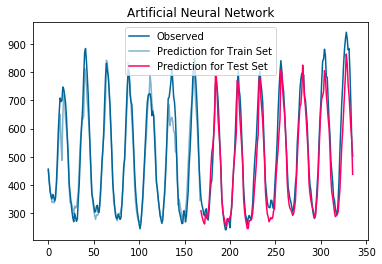

In [20]:
# plot baseline and predictions
plt.plot(aggLoad[5664:5664+168*2].values, label='Observed', color='#006699');
plt.plot(train_predict_plot[5664:5664+168*2], label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot[5664:5664+168*2], label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='best');
plt.title('Artificial Neural Network')
plt.show()